In [260]:
import numpy as np
from numba import njit
from numba_stats import norm

In [541]:
from math import erf, sqrt

@njit
def gaussian_cdf(x):
    return 0.5*(1+erf(x / sqrt(2)))

In [548]:
@njit
def _estimation_uniform_njit(m, n, simulate_scenario, simulate_inner_loss, loss_threshold, inner_loss_std):
    scenarios = simulate_scenario(n)
    inner_losses_mean = np.zeros(n)

    for i, scenario in enumerate(scenarios):
        inner_loss = simulate_inner_loss(scenario=scenario, size=m)
        inner_losses_mean[i] = np.mean(inner_loss)

    estimator = np.mean(inner_losses_mean >= loss_threshold)
    return estimator

@njit
def _estimation_sequential_njit(m_init, m_average, n, simulate_scenario, simulate_inner_loss, loss_threshold, inner_loss_std):
    scenarios = simulate_scenario(n)
    sigmas = inner_loss_std(scenarios)
    m_array = np.zeros(n)
    inner_losses_mean = np.zeros(n)

    for i, scenario in enumerate(scenarios):
        inner_loss = simulate_inner_loss(scenario=scenario, size=m_init)
        inner_losses_mean[i] = np.mean(inner_loss)
    m_array += m_init

    while np.sum(m_array) < m_average * n:
         idx_scenario = np.argmin(m_array * np.abs(inner_losses_mean - loss_threshold) / sigmas)
         new_inner_loss = simulate_inner_loss(scenario=scenarios[idx_scenario], size=1)[0]
         inner_losses_mean[idx_scenario] = m_array[idx_scenario] / (m_array[idx_scenario] + 1) * inner_losses_mean[idx_scenario] + new_inner_loss / (m_array[idx_scenario] + 1)
         m_array[idx_scenario] += 1

    estimator = np.mean(inner_losses_mean >= loss_threshold)

    return (estimator, inner_losses_mean, m_array)

@njit
def _estimation_threshold_njit(error_margin, n, simulate_scenario, simulate_inner_loss, loss_threshold, inner_loss_std):
    scenarios = simulate_scenario(n)
    sigmas = inner_loss_std(scenarios)
    inner_losses_mean = np.zeros(n)

    for i, scenario in enumerate(scenarios):
        inner_loss_mean = 0
        m_scenario = 0
        while m_scenario / sigmas[i] * np.abs(inner_loss_mean - loss_threshold) < error_margin:
            new_inner_loss = simulate_inner_loss(scenario=scenario, size=1)[0]
            inner_loss_mean = m_scenario / (m_scenario + 1) * inner_loss_mean + new_inner_loss / (m_scenario + 1)
            m_scenario += 1
        inner_losses_mean[i] = inner_loss_mean

    estimator = np.mean(inner_losses_mean >= loss_threshold)
    return estimator

@njit
def _estimation_adaptive_njit(n_0, m_0, tau_e, k, simulate_scenario, simulate_inner_loss, loss_threshold, inner_loss_std, estimate_inner_std=False):
    N_MAX = k
    m_average, n = m_0, n_0

    scenarios = np.zeros(N_MAX)
    scenarios[:n] = simulate_scenario(n)
    sigmas = np.zeros(N_MAX)
    if not estimate_inner_std:
        sigmas[:n] = inner_loss_std(scenarios[:n])

    m_array = np.zeros(N_MAX)
    inner_losses_mean = np.zeros(N_MAX)
    if estimate_inner_std:
        squared_inner_losses_mean = np.zeros(N_MAX)

    for i, scenario in enumerate(scenarios[:n]):
        inner_loss = simulate_inner_loss(scenario=scenario, size=m_0)
        inner_losses_mean[i] = np.mean(inner_loss)
        if estimate_inner_std:
            squared_inner_losses_mean[i] = np.mean(inner_loss**2)
    m_array[:n] = m_0
    
    if estimate_inner_std:
        sigmas[:n] = np.sqrt(squared_inner_losses_mean[:n] - inner_losses_mean[:n]**2)

    for l in range(int(np.ceil(k / tau_e))):
        alpha_bar = np.mean(np.array(list(map(gaussian_cdf, m_array[:n] * (inner_losses_mean[:n] - loss_threshold) / sigmas[:n]))))
        alpha_hat = np.mean(inner_losses_mean[:n] >= loss_threshold)
        bias = alpha_hat - alpha_bar
        variance = alpha_bar * (1 - alpha_bar) / n
        n_new = int(min(
            max(((variance * n)**0.2 * (m_average * n + tau_e)**0.8) / (4 * bias**2 * m_average**4)**0.2, n),
            n + tau_e)
        )
        n_to_add = n_new - n
        if n_to_add > 0:
            scenarios_to_add = simulate_scenario(n_to_add) 
            scenarios[n:n_new] = scenarios_to_add
            if not estimate_inner_std:
                 sigmas[n:n_new] = inner_loss_std(scenarios_to_add)

        while np.sum(m_array[:n_new]) < (l + 1) * tau_e:
            idx_scenario = np.argmin(m_array[:n_new]) if np.min(m_array[:n_new]) < m_0 else np.argmin(m_array[:n_new] * np.abs(inner_losses_mean[:n_new] - loss_threshold) / sigmas[:n_new])
            new_inner_loss = simulate_inner_loss(scenario=scenarios[idx_scenario], size=1)[0]
            inner_losses_mean[idx_scenario] = m_array[idx_scenario] / (m_array[idx_scenario] + 1) * inner_losses_mean[idx_scenario] + new_inner_loss / (m_array[idx_scenario] + 1)
            if estimate_inner_std:
                squared_inner_losses_mean[idx_scenario] = m_array[idx_scenario] / (m_array[idx_scenario] + 1) * squared_inner_losses_mean[idx_scenario] + new_inner_loss**2 / (m_array[idx_scenario] + 1)
                sigmas[idx_scenario] = np.sqrt(squared_inner_losses_mean[idx_scenario] - inner_losses_mean[idx_scenario]**2) 
            m_array[idx_scenario] += 1

        m_average, n = np.mean(m_array[:n_new]), n_new
    estimator = np.mean(inner_losses_mean[:n] >= loss_threshold)
    return estimator

In [549]:
class NestedMonteCarlo:
    """
    Hereafter, n stands for the number of scenario simulations, m stands for the number of internal loss simulations par scenario.
    """
    simulate_scenario : callable # function of (size)
    simulate_inner_loss : callable # function of (scenario, size)
    loss_threshold : float
    inner_loss_std: callable # function of (scenario)

    def __init__(self, simulate_scenario, simulate_inner_loss, loss_threshold, inner_loss_std) -> None:
        self.simulate_scenario = simulate_scenario
        self.simulate_inner_loss = simulate_inner_loss
        self.loss_threshold = loss_threshold
        self.inner_loss_std = inner_loss_std

    def estimation_uniform(self, m, n):
        return _estimation_uniform_njit(m, n, self.simulate_scenario, self.simulate_inner_loss, self.loss_threshold, self.inner_loss_std)

    def estimation_sequential(self, m_init, m_average, n, return_info=False):
        estimator, inner_losses_mean, m_array = _estimation_sequential_njit(m_init, m_average, n, self.simulate_scenario, self.simulate_inner_loss, self.loss_threshold, self.inner_loss_std)
        return (estimator, inner_losses_mean, m_array) if return_info else estimator
    
    def estimation_threshold(self, error_margin, n):
        return _estimation_threshold_njit(error_margin, n, self.simulate_scenario, self.simulate_inner_loss, self.loss_threshold, self.inner_loss_std)
    
    def estimation_adaptive(self, n_0, m_0, tau_e, k, estimate_inner_std=False):
        return _estimation_adaptive_njit(n_0, m_0, tau_e, k, self.simulate_scenario, self.simulate_inner_loss, self.loss_threshold, self.inner_loss_std, estimate_inner_std=False)
    

## Gaussian example

In [550]:
sigma_inner = 5
sigma_outer = 1

@njit
def gaussian_simulate_scenario(size):
    return np.random.randn(size) * sigma_outer

@njit
def gaussian_simulate_inner_loss(scenario, size):
    return -scenario + np.random.randn(size) * np.sqrt(sigma_inner)

@njit
def gaussian_inner_std(scenarios):
    return np.ones_like(scenarios) * sigma_inner

threshold_gauss = 2.3263478740408408 # corresponds to loss of 1%
norm.cdf(-threshold_gauss, loc=0, scale=1)

array(0.01)

In [551]:
nested_mc_gauss = NestedMonteCarlo(
    simulate_scenario=gaussian_simulate_scenario,
    simulate_inner_loss=gaussian_simulate_inner_loss,
    loss_threshold=threshold_gauss,
    inner_loss_std=gaussian_inner_std
)

### Sanity check for all algorithms

Optimal values of $n$ and $m$ corresponding to the budget $k = 4 \cdot 10^6$.

In [457]:
n_opt = 4499
m_opt = 889

In [377]:
nested_mc_gauss.estimation_uniform(m=m_opt, n=n_opt)

0.008224049788841965

In [279]:
nested_mc_gauss.estimation_sequential(m_init=2, m_average=m_opt, n=n_opt)

0.008446321404756613

In [421]:
nested_mc_gauss.estimation_threshold(error_margin=50, n=n_opt)

0.00866859302067126

In [ ]:
nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=100_000, k=4_000_000)

In [553]:
nested_mc_gauss.estimation_adaptive(n_0=500, m_0=2, tau_e=100_000, k=100_000, estimate_inner_std=True)

0.010642652476463364

## Put option example

In [ ]:
rng = np.random.default_rng(seed=0xBADBADBAD)

model_params = {
    'S0': 100,
    'K': 95,
    'T': 0.25,
    'tau': 1 / 52,
    'sigma': 0.2,
    'mu': 0.08,
    'r': 0.03,
    'X0': 1.669 # by BS formula
}

@njit
def put_simulate_scenario(size):
    return model_params['S0'] * np.exp(
        (model_params['mu'] - 0.5 * model_params['sigma']**2) * model_params['tau'] + 
         model_params['sigma'] * np.sqrt(model_params['tau']) * np.randon.randn(size)
    )

@njit
def put_simulate_inner_loss(size, scenario):
    S_T = scenario * np.exp(
        (model_params['r'] - 0.5 * model_params['sigma']**2) * (model_params['T'] - model_params['tau']) + 
         model_params['sigma'] * np.sqrt(model_params['T'] - model_params['tau']) * np.random.randn(size)
    )
    return model_params['X0'] - np.exp(-model_params['r'] * (model_params['T'] - model_params['tau'])) * np.maximum(0, model_params['K'] - S_T)

@njit
def bs_put(scenario):
    """
    Calculates the value of the put option with expiration T and strike K at t = tau given the scenario S_tau.
    """
    S_tau, K, T, tau, sigma, r = scenario, model_params['K'], model_params['T'], model_params['tau'], model_params['sigma'], model_params['r']
    d1 = (np.log(S_tau / K) + (r + 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    d2 = (np.log(S_tau / K) + (r - 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    return K * np.exp(-r * (T - tau)) * gaussian_cdf(-d2) - S_tau * gaussian_cdf(-d1)

@njit
def bs_inner_vol(scenario):
    """
    Calculates standard deviation for a given scenario S_tau.
    """
    S_tau, K, T, tau, sigma, r = scenario, model_params['K'], model_params['T'], model_params['tau'], model_params['sigma'], model_params['r']
    d1 = (np.log(S_tau / K) + (r + 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    d2 = (np.log(S_tau / K) + (r - 0.5 * sigma**2) * (T - tau)) / sigma / np.sqrt(T - tau)
    second_moment = np.exp(-2 * r * (T - tau)) * K**2 * gaussian_cdf(-d2) - 2 * K * S_tau * np.exp(-r * (T - tau)) * gaussian_cdf(-d1) + \
        S_tau**2 * np.exp(sigma**2 * (T - tau)) * gaussian_cdf(-d2 - 2 * sigma * np.sqrt(T - tau))
    return np.sqrt(second_moment - bs_put(scenario)**2)

@njit
def bs_inner_vol_vect(scenarios):
    return np.array(list(map(bs_inner_vol, scenarios)))

threshold_put = 1.221 # corresponds to loss of 1%

In [ ]:
nested_mc_put = NestedMonteCarlo(
    simulate_scenario=put_simulate_scenario,
    simulate_inner_loss=put_simulate_inner_loss,
    loss_threshold=threshold_put,
    inner_loss_std=bs_inner_vol
)

### Sanity check for all algorithms

In [66]:
# optimal uniform
nested_mc_put.estimation_uniform(m=m_opt, n=n_opt)

0.011780395643476329

In [67]:
# 1/3:2/3 uniform
nested_mc_put.estimation_uniform(m=159, n=25199)

0.02091352831461566

In [41]:
nested_mc_put.estimation_sequential(m_init=10, m_average=m_opt, n=n_opt)

0.010224494332073794

In [42]:
nested_mc_put.estimation_threshold(error_margin=50, n=n_opt)

0.009557679484329852

In [68]:
nested_mc_put.estimation_adaptive(n_0=500, m_0=2, tau_e=100_000, k=m_opt*n_opt)

0.009795497508162915

In [90]:
nested_mc_put.estimation_adaptive(n_0=500, m_0=10, tau_e=100_000, k=m_opt*n_opt, estimate_inner_std=True)

0.06375092661230541

### Number of inner stage samples 

In [457]:
import matplotlib.pyplot as plt

In [406]:
_, inner_losses_mean_gauss, m_array_gauss = nested_mc_gauss.estimation_sequential(m_init=10, m_average=m_opt, n=n_opt, return_info=True)
_, inner_losses_mean_put, m_array_put = nested_mc_put.estimation_sequential(m_init=10, m_average=m_opt, n=n_opt, return_info=True)

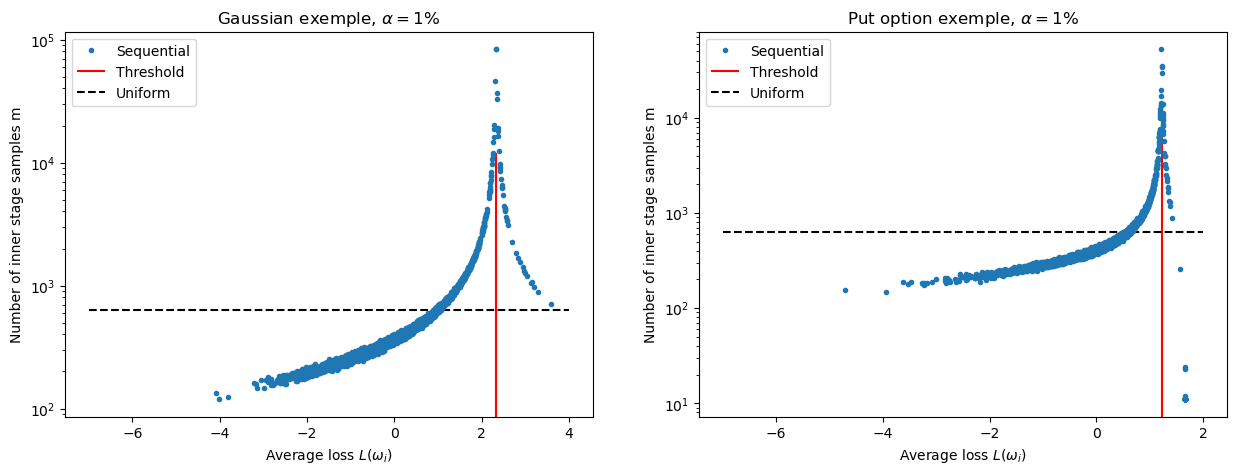

In [459]:
fix, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(inner_losses_mean_gauss, m_array_gauss, '.', label='Sequential')
ax[0].vlines(x=threshold_gauss, ymin=0, ymax=12000, color='r', label='Threshold')
ax[0].hlines(m, -7, 4, color='k', ls='--', label='Uniform')
ax[0].legend()
ax[0].set_title(r'Gaussian exemple, $\alpha = 1\%$')
ax[0].set_xlabel('Average loss $L(\omega_i)$')
ax[0].set_ylabel('Number of inner stage samples m')
ax[0].set_yscale('log')

ax[1].plot(inner_losses_mean_put, m_array_put, '.', label='Sequential')
ax[1].vlines(x=threshold_put, ymin=0, ymax=12000, color='r', label='Threshold')
ax[1].hlines(m, -7, 2, color='k', ls='--', label='Uniform')
ax[1].legend()
ax[1].set_title(r'Put option exemple, $\alpha = 1\%$')
ax[1].set_xlabel('Average loss $L(\omega_i)$')
ax[1].set_ylabel('Number of inner stage samples m')
ax[1].set_yscale('log')

ToDo:
- Estimate the error distribution for each method (see the table in the article + plot histograms) for alpha = 1%